In [1]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


Four-point sensitivities
------------------------

In this example, we illustrate how to visualize the sensitivities of four-point
arrays. You can easily loop over the plotting command to create something like:
https://www.youtube.com/watch?v=lt1qV-2d5Ps


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

We start by creating a ERT data container with three four-point arrays.



In [3]:
xmin, xmax = [0, 30]
dx = 1.0    # espaçamento entre eletrodos (em metros)

ymin, ymax = [0, -10]




posicoes = np.array((                  # posições dos eletrodos em metros
    [0, 1, 2, 3],  # arranjo 1
    [0, 1, 3, 4],  # arranjo 2
    [0, 1, 4, 5]   # arranjo 3
))

In [4]:
scheme = pg.DataContainerERT()

nelecs = int((xmax-xmin)/dx + 1)
pos = np.zeros((nelecs, 2))
pos[:, 0] = np.linspace(xmin, xmax, nelecs)

scheme.setSensorPositions(pos)




measurements = np.zeros(posicoes.shape)
passos = posicoes.shape[0]

for p in range(passos):
    measurements[p, :] = [np.abs(pos[:, 0]-i).argmin() for i in posicoes[p, :]]     # pega os índices das posições dos eletrodos
    
for i, elec in enumerate("abmn"):
    scheme[elec] = measurements[:,i]

scheme["k"] = ert.createGeometricFactors(scheme)

04/03/21 - 12:09:26 - pyGIMLi - INFO - Cache C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\physics\ert\ert.py:createGeometricFactors restored (0.0s x 7): C:\Users\Emerson\AppData\Roaming\pygimli\Cache\2386796284484951761


Now we set up a 2D mesh.



04/03/21 - 12:09:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 2 within mesh.
C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\viewer\mpl\colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x4cff5c9688>)

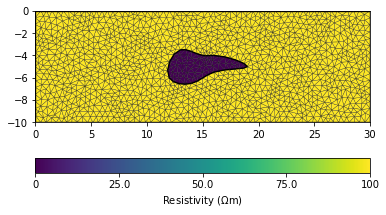

In [5]:
world = mt.createWorld(start=[xmin, ymin], end=[xmax, ymax], worldMarker=True)
for pos in scheme.sensorPositions():
    world.createNode(pos)

corpo = np.array([(1,-4), (2,-1.5), (4,-2), (5,-2), (8,-3), (5,-3.5), (3,-4.5)])

corpo[:, 0] += 11
corpo[:, 1] -= 2

poly = mt.createPolygon(corpo, isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

rhomap = [[1, 100.],
          [2, 25.0]]


mesh = mt.createMesh(world + poly, area=.2, quality=32, marker=1)

pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

As a last step we invoke the ERT manager and calculate the Jacobian for a
homogeneous half-space.



In [6]:
fop = ert.ERTModelling()
fop.setData(scheme)
fop.setMesh(mesh, rhomap)

model = np.ones(mesh.cellCount())
fop.createJacobian(model)

Final visualization



RuntimeError: C:/msys64/home/halbm/gimli/gimli/core/src/vector.h: 671		GIMLI::Vector<ValueType>& GIMLI::Vector<ValueType>::operator/=(const GIMLI::Vector<ValueType>&) [with ValueType = double]  6 != 2482

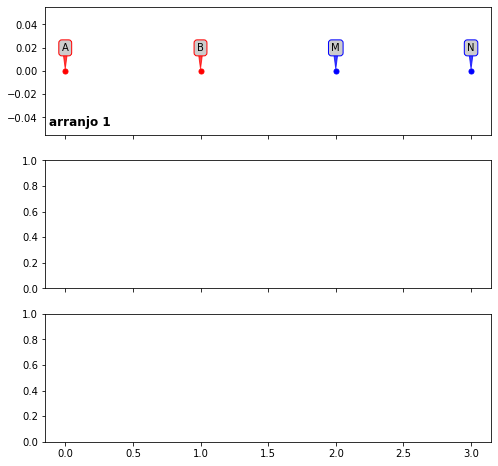

In [7]:
def getABMN(scheme, idx):
    """ Get coordinates of four-point cfg with id `idx` from DataContainerERT
    `scheme`."""
    coords = {}
    for elec in "abmn":
        elec_id = int(scheme(elec)[idx])
        elec_pos = scheme.sensorPosition(elec_id)
        coords[elec] = elec_pos.x(), elec_pos.y()
    return coords


def plotABMN(ax, scheme, idx):
    """ Visualize four-point configuration on given axes. """
    coords = getABMN(scheme, idx)
    for elec in coords:
        x, y = coords[elec]
        if elec in "ab":
            color = "red"
        else:
            color = "blue"
        ax.plot(x, y, marker=".", color=color, ms=10)
        ax.annotate(elec.upper(), xy=(x, y), size=12, ha="center", fontsize=10, bbox=dict(
            boxstyle="round", fc=(0.8, 0.8, 0.8), ec=color), xytext=(0, 20),
                    textcoords='offset points', arrowprops=dict(
                        arrowstyle="wedge, tail_width=.5", fc=color, ec=color,
                        patchA=None, alpha=0.75))
        ax.plot(coords["a"][0],)

labels = ["arranjo 1", "arranjo 2", "arranjo 3"]
fig, ax = plt.subplots(scheme.size(), 1, sharex=True, figsize=(8,8))
for i, sens in enumerate(fop.jacobian()):
    # Label in lower-left corner
    ax[i].text(.01, .15, labels[i], horizontalalignment='left',
               verticalalignment='top', transform=ax[i].transAxes, fontsize=12,
               fontweight="bold")

    # Electrode annotations
    plotABMN(ax[i], scheme, i)

    # Log-scaled and normalized sensitivity
    normsens = pg.utils.logDropTol(sens/mesh.cellSizes(), 8e-4)
    normsens /= np.max(normsens)
    pg.show(mesh, normsens, cMap="RdGy_r", ax=ax[i], orientation="vertical",
            label="Normalized\nsensitivity", nLevs=3, cMin=-1, cMax=1)